# Introduction

This notebook demonstrates hybrid cnn with one layer of quantum for multi-class classification problem using eurosat dataset and realamplitudes circuit as the hidden layer.

# Runtime req

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q torch
!pip install -q matplotlib
!pip install -q visualkeras
!pip install -q qiskit
!pip install pylatexenc
!pip install torchsummary

!unzip -q "/content/drive/MyDrive/colab_notebooks/IITD-QML/EuroSAT_RGB.zip"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 15.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
import qiskit
import sys
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import random
import time
from torchsummary import summary
from collections import defaultdict

import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

from qiskit import *
provider = qiskit
backend = Aer.get_backend("aer_simulator", device="GPU")


## GPU and CPU detection choice

This notebook is used with google colab with Tesla V100 GPU in Python 3 Google Compute Engine backend (GPU).

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9733432124212879593
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14166392832
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6313883678229104436
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
 xla_global_id: 416903419]

# Dataset handling for loading, splitting, training.

The following section has the utilities required for operating with the data.
- [__init__] Detect list of classes from the dataset root directory provided ( inside the constructor )
- [load_paths_labels] Load path labels, ( image paths and labels per class ) and shuffle the data set to generate randomness.
- [cnn_data_loader] Provide a generator which can be provided into the torch circuit with random **training** data set selection insde the training or test data set.
- [cnn_val_loader] Provide a generator which can be provided into the torch circuit with random **validation** data set selection insde the training or test data set.

## Loading strategy

At the time of the training, for each epoch, the dataset is loaded with the generator pattern as listed in the functions below. Two types of strategies can be used for that depending on the need of the training.
- Random selection of training set data point.
- Sequential selection of training set data point.

The only advantage of using sequantial method is that the dataset will be fully used for training and there is less probability of that in random selection.
At the end of each epoch, the counter is reset. If some randomness is desired there, we can shuffle the dataset before starting an epoch.

## Image loading from disk

There is some minor amount of advantage received for storing the dataset in memory, python dict when running training epochs. This method would not work well when the training dataset is huge and cannot be fit into memory.

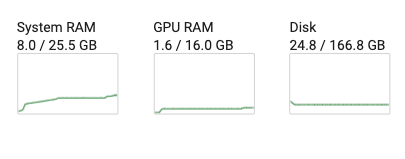

## Splitting

Training and validation datasets are loaded and shuffled. After that there is a 0.2 split factor applied to test dataset.

In [ ]:
class DatasetHandler:
    def __init__(self, ds_root_path):
        print ('Datahandler init -> ', ds_root_path)
        self.dataset_path = ds_root_path
        self.classes = glob.glob(os.path.join(ds_root_path, '*'))
        self.classes_dict = {}
        for c, i in zip(self.classes, range(len(self.classes))):
          self.classes_dict[c] = i
        self.dataset_mixer = 0
        self.dataset_mixer_val = 0
        self.img_cache = {}
        self.img_cache_val = {}

    def print_classes(self):
        print('Classes in the path: ')
        for i,c in enumerate(self.classes):
            print(i, ' ->', c)

    def load_paths_labels(self, root, classes):
        imgs_path = []
        imgs_label = []

        for clss in classes:
            for path in glob.glob(os.path.join(root, clss+'/*')):
              imgs_path.append(path)
              imgs_label.append(self.classes_dict[clss])

        dataset = list(zip(imgs_path, imgs_label))
        random.shuffle(dataset)
        paths, labels = zip(*dataset)
        return np.array(paths), np.array(labels)

    def train_validation_split(self, images, labels, split_factor = 0.2):
        val_size = int(len(images)*split_factor)
        train_size = int(len(images) - val_size)
        return images[0:train_size], labels[0:train_size, ...], images[train_size:train_size+val_size], labels[train_size:train_size+val_size, ...]

    def cnn_data_loader(self, imgs_path, imgs_label, batch_size = 1, img_shape = (64, 64, 3), vald=False):
      batch_in = np.zeros((batch_size, img_shape[2], img_shape[0], img_shape[1]))
      batch_out = np.zeros((batch_size))

      from collections import defaultdict

      while True:
        for i in range(batch_size):
          index = self.dataset_mixer
          self.dataset_mixer += 1
          if self.dataset_mixer >= len(imgs_path):
            self.dataset_mixer = 0

          if index not in self.img_cache:
            self.img_cache[index] = np.transpose(plt.imread(imgs_path[index])/255.0)

          batch_in[i, ...] = self.img_cache[index]
          batch_out[i] = imgs_label[index]
          yield  torch.tensor(batch_in).type(torch.float).to(device),  torch.tensor(batch_out).type(torch.float).to(device)

    def cnn_val_loader(self, imgs_path, imgs_label, batch_size = 1, img_shape = (64, 64, 3), vald=False):
      # Initialize the vectors to be yielded for training.
      batch_in = np.zeros((batch_size, img_shape[2], img_shape[0], img_shape[1]))
      batch_out = np.zeros((batch_size))

      from collections import defaultdict

      while True:
        for i in range(batch_size):
          index = self.dataset_mixer_val
          self.dataset_mixer_val += 1
          if self.dataset_mixer_val >= len(imgs_path):
            self.dataset_mixer_val = 0

          if index not in self.img_cache_val:
            self.img_cache_val[index] = np.transpose(plt.imread(imgs_path[index])/255.0)

          batch_in[i, ...] = self.img_cache_val[index]
          batch_out[i] = imgs_label[index]
          yield  torch.tensor(batch_in).type(torch.float).to(device),  torch.tensor(batch_out).type(torch.float).to(device)



## System path
The exectution environment in colab has persistent storage linked to google drive so that we can read the dataset and also store models back.

In [ ]:
sys.path.append('/content/drive/MyDrive/colab_notebooks/IITD-QML/')
dataset_root_path = '/content/EuroSAT_RGB'


In [ ]:
handler = DatasetHandler(dataset_root_path)
imgs_path, imgs_label = handler.load_paths_labels(dataset_root_path, handler.classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

Datahandler init ->  /content/EuroSAT_RGB
Dataset images: 27000 Dataset labels: 27000
Dataset sample -> /content/EuroSAT_RGB/Forest/Forest_820.jpg 3


In [ ]:
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape)

X_train shape: (21600,) Y_train shape: (21600,)
  X_val shape:  (5400,)   Y_val shape:  (5400,)


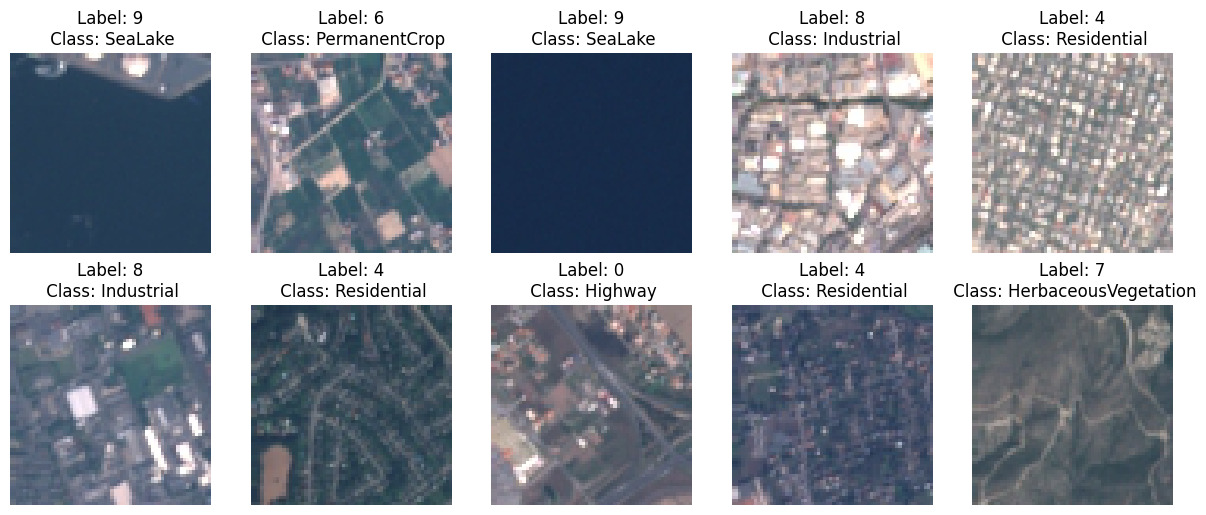

In [ ]:
def plotDataset(images, labels, classes, columns, rows):
    fig, axes = plt.subplots(nrows = rows, ncols = columns, figsize = (columns*3,rows*3))
    for x in range(columns):
        for y in range(rows):
            index = random.randint(0, len(images)-1)

            axes[y,x].imshow(plt.imread(images[index]))
            axes[y,x].set_title('Label: ' + str(labels[index]) +
                                '\n Class: ' + classes[labels[index]].split('/')[-1])
            axes[y,x].axis(False)

    plt.show()
plotDataset(train_imgs, train_labels, handler.classes, columns = 5, rows = 2)

# Quantum classification layer.

The code below is run with usage of 4 Qubits as per the circuit defined as QCNeuron with Aer Simulator.

In [ ]:
NUM_QUBITS = 4
NUM_SHOTS = 750
SHIFT = np.pi/4

SIMULATOR = Aer.get_backend('aer_simulator')

## Quantum circuit to be embedded into the layer.

The following circuit code below, generates a bell circuit of 4 Qubits for usage in the CNN down under.
4 Qubit circuit generates, 16 states which can be used as inputs to the state next.
The previous layer in quantum has 4 as outputs which are connected to the QC circuit as inputs.

In [ ]:
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


In [ ]:
class QCNeuron():
    def __init__(self, n_qubits, backend, shots):
        self.qc = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas = {k : Parameter('Theta'+str(k))for k in range(2*self.n_qubits)}

        all_qubits = [i for i in range(n_qubits)]
        self.qc.h(all_qubits)
        self.qc.barrier()

        for k in range(0, 4):
          self.qc.ry(self.thetas[k], k)

        self.qc.barrier()

        self.qc.cx(1, 0)
        self.qc.cx(2, 0)
        self.qc.cx(3, 0)
        self.qc.cx(2, 1)
        self.qc.cx(3, 1)
        self.qc.cx(3, 2)
        self.qc.barrier()

        for k in range(0, 4):
          self.qc.ry(self.thetas[k+4], k)

        self.qc.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots

        self.tqc = transpile(self.qc, backend=self.backend)


    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0)/shots
            expects[k] = perc
        return expects

    def run(self, i):
        params = i.cpu().data.numpy()
        parameters = {}

        for k in range(2*self.n_qubits):
          parameters[self.thetas[k]] = params[k].item()

        qobj = assemble(self.tqc,
                        shots=self.shots,
                        parameter_binds = [parameters])

        job = self.backend.run(qobj)
        res =  self.N_qubit_expectation_Z(job.result().get_counts(), self.shots, self.n_qubits)
        return res

## Sample QC circuit with 8 parameters

In [ ]:
circuit = QCNeuron(NUM_QUBITS, Aer.get_backend('aer_simulator', device="GPU"), NUM_SHOTS)
circuit.qc.draw(fold=2000)

┌───┐ ░ ┌────────────┐ ░ ┌───┐┌───┐┌───┐                ░ ┌────────────┐ ░ ┌─┐         
   q_0: ┤ H ├─░─┤ Ry(Theta0) ├─░─┤ X ├┤ X ├┤ X ├────────────────░─┤ Ry(Theta4) ├─░─┤M├─────────
        ├───┤ ░ ├────────────┤ ░ └─┬─┘└─┬─┘└─┬─┘┌───┐┌───┐      ░ ├────────────┤ ░ └╥┘┌─┐      
   q_1: ┤ H ├─░─┤ Ry(Theta1) ├─░───■────┼────┼──┤ X ├┤ X ├──────░─┤ Ry(Theta5) ├─░──╫─┤M├──────
        ├───┤ ░ ├────────────┤ ░        │    │  └─┬─┘└─┬─┘┌───┐ ░ ├────────────┤ ░  ║ └╥┘┌─┐   
   q_2: ┤ H ├─░─┤ Ry(Theta2) ├─░────────■────┼────■────┼──┤ X ├─░─┤ Ry(Theta6) ├─░──╫──╫─┤M├───
        ├───┤ ░ ├────────────┤ ░             │         │  └─┬─┘ ░ ├────────────┤ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ H ├─░─┤ Ry(Theta3) ├─░─────────────■─────────■────■───░─┤ Ry(Theta7) ├─░──╫──╫──╫─┤M├
        └───┘ ░ └────────────┘ ░                                ░ └────────────┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                    0  1  2  3

## Circuit test

Test data for the quantum run test for 8 parameters to 16 outcomes for 4 Qubits.

In [ ]:
np_array = np.array([5, 7, 1, 2,8,7,6,5])

# Convert Numpy array to torch.Tensor
tensor_a = torch.from_numpy(np_array)

circuit.run(tensor_a)

<ipython-input-34-11ec6e9f6fc5>:56: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


array([0.06533333, 0.        , 0.04133333, 0.15733333, 0.00133333,
       0.        , 0.        , 0.00666667, 0.128     , 0.00666667,
       0.13733333, 0.38666667, 0.02533333, 0.032     , 0.        ,
       0.012     ])

## Quantum neural network hidden layer

In [ ]:
class QuantumLayer(Function):
    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'qc'):
            ctx.qc = QCNeuron(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)

        exp_value = ctx.qc.run(i)
        result = torch.tensor([exp_value]).to(device)
        ctx.save_for_backward(result, i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        forward_tensor, i = ctx.saved_tensors
        input_numbers = i
        gradients = torch.Tensor()

        for k in range(2*NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT

            expectation_right = ctx.qc.run(shift_right)
            expectation_left  = ctx.qc.run(shift_left)

            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients = torch.cat((gradients, gradient.float()))

        result = torch.Tensor(gradients).to(device)

        return (result.float() * grad_output.float()).T

# CNN

The CNN below is the convlution neural network that holds the quantum layer. The following are the blocks inside the CNN.

- Convolution (3-16)
- Maxpool 2d
- Convolution (16-32)
- Maxpool 2d
- Convolution (32-64)
- Maxpool 2d
- Flatten (2304)
- Fully connected (2304-8)
- Tanh sigmoid
- **Quantum layer (8-16)**
- Relu
- Fully connected 16 - 10
- Softmax


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)

        self.fc1 = nn.Linear(2304, 8)
        self.qc = QuantumLayer.apply
        self.fc2 = nn.Linear(16, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))

        x = x.view(-1, 2304)
        x = self.fc1(x)
        x = np.pi*torch.tanh(x)

        ## Quantum circuit
        x = self.qc(x[0])
        x = F.relu(x)
        ##
        x = self.fc2(x.float())
        x = F.softmax(x, 1)
        return x


    def predict(self, x):
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)

hybrid_network = Net().to(device)
optimizer = optim.Adam(hybrid_network.parameters(), lr=0.0002)

## Saving and loading state

Due to runtime problems like disconnection of vm, overnight inactivity problems during epochs, the model is saved so that it can be resumed to restore the state of the training.

In [ ]:
hybrid_network = Net().to(device)
optimizer = optim.Adam(hybrid_network.parameters(), lr=0.0002)

checkpoint = torch.load('/content/drive/MyDrive/colab_notebooks/IITD-QML/model-multi-class-hybrid-lenet5-modif-real-amplitudes.pt')
hybrid_network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

hybrid_network.eval()
# - or -
hybrid_network.train()

In [ ]:
summary(hybrid_network, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
            Conv2d-2           [-1, 32, 29, 29]           4,640
            Conv2d-3           [-1, 64, 12, 12]          18,496
            Linear-4                    [-1, 8]          18,440
            Linear-5                   [-1, 10]             170
Total params: 42,194
Trainable params: 42,194
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.75
Params size (MB): 0.16
Estimated Total Size (MB): 0.95
----------------------------------------------------------------


<ipython-input-34-11ec6e9f6fc5>:56: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


In [ ]:
train_loss_list = []
val_loss_list = []
epochs = 20

loss_func = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(epochs):
  train_loader = iter(handler.cnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
  test_loader = iter(handler.cnn_val_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
  total_loss = []
  for batch_idx in range(len(train_labels)):
    data, target = next(train_loader)
    optimizer.zero_grad()
    output = hybrid_network(data)
    target = target.type(torch.LongTensor).to(device)
    loss = loss_func(output, target)
    loss.backward()
    optimizer.step()

    total_loss.append(loss.item())

    print('\rEpoch %d ~ Batch %d (%d) ~ Loss %f ' % (epoch, batch_idx, len(train_imgs)-1, loss.item()), end='\t\t')


  with torch.no_grad():
    val_loss = []
    targets = []
    predictions = []
    for batch_idx in range(len(val_images)):
      data, target = next(test_loader)
      output = hybrid_network(data)
      target = target.type(torch.LongTensor).to(device)
      loss = loss_func(output, target)
      val_loss.append(loss.item())
      targets.append(target.item())
      predictions.append(hybrid_network.predict(data).item())


    train_loss_list.append(sum(total_loss)/len(total_loss))
    val_loss_list.append(sum(val_loss)/len(val_loss))

    print('Training [{:.0f}%]\t Training Loss: {:.4f} Validation Loss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, train_loss_list[-1], val_loss_list[-1]))

    print(confusion_matrix(targets, predictions,normalize='true'))
    print(classification_report(targets, predictions, target_names=handler.classes, digits=4, labels=np.unique(predictions)))

    torch.save({
            'epoch': epoch,
            'model_state_dict': hybrid_network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_list[-1],
            }, '/content/drive/MyDrive/colab_notebooks/IITD-QML/model-multi-class-hybrid-lenet5-modif-real-amplitudes.pt')


<ipython-input-16-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 0 ~ Batch 21599 (21599) ~ Loss 2.427977 		Training [5%]	 Training Loss: 1.6911 Validation Loss: 1.6883
[[0.78781925 0.06286837 0.01375246 0.00196464 0.043222   0.00982318
  0.         0.06090373 0.01571709 0.00392927]
 [0.08401639 0.84221311 0.0204918  0.0204918  0.00204918 0.0204918
  0.         0.00409836 0.00409836 0.00204918]
 [0.03422983 0.07823961 0.62836186 0.09535452 0.         0.01711491
  0.         0.13447433 0.         0.01222494]
 [0.         0.00160772 0.01286174 0.95176849 0.         0.
  0.         0.01607717 0.         0.01768489]
 [0.00161031 0.         0.         0.         0.98389694 0.
  0.         0.00322061 0.01127214 0.        ]
 [0.04582651 0.05728314 0.03109656 0.00654664 0.00327332 0.76923077
  0.00163666 0.07037643 0.         0.01472995]
 [0.22417154 0.06432749 0.02534113 0.         0.03508772 0.04483431
  0.01169591 0.57894737 0.01559454 0.        ]
 [0.00516351 0.00344234 0.00860585 0.01893287 0.04302926 0.00688468
  0.         0.90189329 0.00172117 

<ipython-input-16-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 1 ~ Batch 21599 (21599) ~ Loss 2.085674 		Training [10%]	 Training Loss: 1.6646 Validation Loss: 1.6749
[[0.83300589 0.05697446 0.03143418 0.00196464 0.02554028 0.00392927
  0.01964637 0.01375246 0.00785855 0.00589391]
 [0.09016393 0.82991803 0.04303279 0.01229508 0.00204918 0.01434426
  0.00204918 0.         0.         0.00614754]
 [0.02200489 0.04400978 0.82640587 0.01222494 0.         0.0195599
  0.00733496 0.04400978 0.         0.02444988]
 [0.         0.         0.05466238 0.87459807 0.         0.
  0.         0.00643087 0.         0.06430868]
 [0.00161031 0.         0.         0.         0.99033816 0.
  0.         0.         0.00805153 0.        ]
 [0.02291326 0.04909984 0.04091653 0.         0.00163666 0.78559738
  0.03273322 0.03436989 0.         0.03273322]
 [0.21442495 0.05653021 0.05263158 0.         0.0331384  0.04483431
  0.21442495 0.37037037 0.01364522 0.        ]
 [0.01032702 0.00516351 0.02581756 0.01376936 0.05335628 0.00172117
  0.01549053 0.85370052 0.00172117

<ipython-input-16-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 2 ~ Batch 21599 (21599) ~ Loss 2.424196 		Training [15%]	 Training Loss: 1.6429 Validation Loss: 1.6878
[[0.73084479 0.0589391  0.00785855 0.00982318 0.05304519 0.01178782
  0.04518664 0.05304519 0.02554028 0.00392927]
 [0.09221311 0.78688525 0.0102459  0.02663934 0.01844262 0.03688525
  0.01434426 0.00614754 0.00204918 0.00614754]
 [0.02200489 0.10268949 0.62347188 0.06112469 0.         0.03667482
  0.03178484 0.10268949 0.         0.0195599 ]
 [0.         0.00160772 0.02090032 0.94694534 0.         0.
  0.00160772 0.02733119 0.         0.00160772]
 [0.00161031 0.         0.         0.         0.98711755 0.
  0.00161031 0.         0.00966184 0.        ]
 [0.01636661 0.06055646 0.01145663 0.00490998 0.00163666 0.72176759
  0.08183306 0.07855974 0.         0.02291326]
 [0.07017544 0.03118908 0.00584795 0.         0.04483431 0.02339181
  0.30994152 0.49317739 0.0214425  0.        ]
 [0.00516351 0.00172117 0.00344234 0.02065404 0.0464716  0.01032702
  0.0292599  0.8777969  0.0034423

<ipython-input-16-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 3 ~ Batch 21599 (21599) ~ Loss 2.429615 		Training [20%]	 Training Loss: 1.6262 Validation Loss: 1.8907
[[0.58742633 0.05500982 0.00785855 0.00589391 0.18860511 0.01768173
  0.06679764 0.05304519 0.01768173 0.        ]
 [0.06352459 0.66188525 0.01434426 0.01639344 0.07581967 0.05532787
  0.06762295 0.04098361 0.00204918 0.00204918]
 [0.01222494 0.06845966 0.5403423  0.08312958 0.00244499 0.00733496
  0.1198044  0.15892421 0.         0.00733496]
 [0.         0.00160772 0.02250804 0.65594855 0.         0.
  0.04662379 0.26688103 0.         0.00643087]
 [0.01610306 0.         0.         0.         0.95008052 0.
  0.02898551 0.00161031 0.00322061 0.        ]
 [0.03764321 0.18657938 0.02454992 0.02454992 0.02618658 0.24222586
  0.2487725  0.20294599 0.         0.00654664]
 [0.02923977 0.01754386 0.         0.         0.35282651 0.00389864
  0.20467836 0.37816764 0.01364522 0.        ]
 [0.01032702 0.         0.00172117 0.00516351 0.25989673 0.02753873
  0.01893287 0.67641997 0.       

<ipython-input-16-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 4 ~ Batch 21599 (21599) ~ Loss 1.675351 		Training [25%]	 Training Loss: 1.6157 Validation Loss: 1.6971
[[0.77603143 0.05108055 0.01964637 0.         0.03929273 0.00392927
  0.05304519 0.01964637 0.03536346 0.00196464]
 [0.08606557 0.79098361 0.05327869 0.01844262 0.00204918 0.01434426
  0.0204918  0.         0.0102459  0.00409836]
 [0.01711491 0.07579462 0.72127139 0.07090465 0.00733496 0.00733496
  0.04156479 0.05378973 0.         0.00488998]
 [0.         0.00160772 0.02090032 0.89389068 0.         0.
  0.00160772 0.01446945 0.         0.06752412]
 [0.00322061 0.         0.         0.         0.96296296 0.
  0.         0.         0.03381643 0.        ]
 [0.03764321 0.10638298 0.03436989 0.00654664 0.00163666 0.53846154
  0.15384615 0.101473   0.         0.01963993]
 [0.08966862 0.04678363 0.00389864 0.00194932 0.04288499 0.
  0.39181287 0.39181287 0.03118908 0.        ]
 [0.01032702 0.00516351 0.00344234 0.02409639 0.05679862 0.00172117
  0.06884682 0.81755594 0.00860585 0.0034

<ipython-input-16-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 5 ~ Batch 21599 (21599) ~ Loss 1.530963 		Training [30%]	 Training Loss: 1.6015 Validation Loss: 1.6516
[[0.78585462 0.05500982 0.01375246 0.00196464 0.04125737 0.
  0.0589391  0.01571709 0.02554028 0.00196464]
 [0.0942623  0.81557377 0.01229508 0.01639344 0.01434426 0.0102459
  0.02663934 0.00409836 0.00409836 0.00204918]
 [0.00488998 0.04889976 0.79462103 0.04400978 0.         0.00733496
  0.05134474 0.04400978 0.         0.00488998]
 [0.         0.00321543 0.01446945 0.90192926 0.         0.
  0.00643087 0.02250804 0.         0.05144695]
 [0.00483092 0.         0.         0.         0.98228663 0.
  0.         0.00483092 0.00805153 0.        ]
 [0.02618658 0.07692308 0.02291326 0.00490998 0.00163666 0.68248773
  0.14566285 0.02291326 0.         0.01636661]
 [0.08382066 0.02339181 0.01364522 0.00194932 0.03898635 0.00779727
  0.69005848 0.11500975 0.02534113 0.        ]
 [0.01376936 0.         0.02065404 0.00172117 0.0464716  0.00860585
  0.12564544 0.77280551 0.00344234 0.00688

<ipython-input-16-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 6 ~ Batch 21599 (21599) ~ Loss 1.504799 		Training [35%]	 Training Loss: 1.5903 Validation Loss: 1.6357
[[0.80157171 0.04911591 0.02554028 0.00196464 0.00785855 0.00785855
  0.07269155 0.00982318 0.021611   0.00196464]
 [0.07786885 0.82172131 0.03278689 0.01434426 0.         0.02663934
  0.01229508 0.00409836 0.00204918 0.00819672]
 [0.00488998 0.05134474 0.73838631 0.13691932 0.         0.00733496
  0.0391198  0.0195599  0.         0.00244499]
 [0.         0.         0.00482315 0.93729904 0.         0.
  0.         0.00321543 0.         0.05466238]
 [0.00644122 0.         0.         0.         0.95008052 0.00161031
  0.00966184 0.00966184 0.02254428 0.        ]
 [0.00818331 0.06382979 0.03436989 0.00654664 0.00163666 0.7594108
  0.09001637 0.02618658 0.         0.00981997]
 [0.08576998 0.04093567 0.02534113 0.00194932 0.01169591 0.01559454
  0.73684211 0.07407407 0.00779727 0.        ]
 [0.01549053 0.00172117 0.01549053 0.03270224 0.01376936 0.00344234
  0.13425129 0.76419966 0.

<ipython-input-16-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 7 ~ Batch 21599 (21599) ~ Loss 1.480214 		Training [40%]	 Training Loss: 1.5848 Validation Loss: 1.6435
[[0.76817289 0.04518664 0.01768173 0.00982318 0.02750491 0.00196464
  0.06876228 0.03732809 0.021611   0.00196464]
 [0.10655738 0.76639344 0.02868852 0.03483607 0.00819672 0.01434426
  0.02663934 0.00614754 0.00409836 0.00409836]
 [0.00733496 0.05867971 0.76528117 0.07579462 0.         0.00488998
  0.02444988 0.06112469 0.         0.00244499]
 [0.         0.00160772 0.00643087 0.94051447 0.         0.
  0.00160772 0.01446945 0.         0.03536977]
 [0.00483092 0.         0.         0.         0.96457327 0.00322061
  0.00161031 0.00161031 0.02415459 0.        ]
 [0.02618658 0.07037643 0.02782324 0.00654664 0.         0.73977087
  0.06382979 0.05237316 0.         0.01309329]
 [0.0662768  0.02534113 0.00974659 0.00194932 0.00974659 0.01169591
  0.57894737 0.27680312 0.01949318 0.        ]
 [0.01204819 0.00172117 0.01549053 0.02237522 0.01549053 0.00344234
  0.06196213 0.8605852  0

<ipython-input-16-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 8 ~ Batch 21599 (21599) ~ Loss 1.481333 		Training [45%]	 Training Loss: 1.5760 Validation Loss: 1.6566
[[0.74066798 0.08840864 0.02554028 0.00196464 0.01964637 0.00196464
  0.07662083 0.021611   0.02357564 0.        ]
 [0.05942623 0.85040984 0.02459016 0.01639344 0.00204918 0.01229508
  0.02254098 0.00614754 0.         0.00614754]
 [0.00244499 0.05378973 0.82151589 0.03178484 0.         0.
  0.0391198  0.04645477 0.         0.00488998]
 [0.         0.00160772 0.0096463  0.9807074  0.         0.
  0.         0.00643087 0.         0.00160772]
 [0.00322061 0.         0.         0.         0.96457327 0.
  0.00483092 0.00805153 0.01932367 0.        ]
 [0.00490998 0.08674304 0.0801964  0.01145663 0.         0.5400982
  0.16693944 0.10310966 0.         0.00654664]
 [0.04093567 0.02923977 0.0331384  0.00584795 0.00974659 0.00974659
  0.67251462 0.19298246 0.00584795 0.        ]
 [0.01376936 0.00172117 0.0172117  0.0464716  0.01893287 0.00688468
  0.0757315  0.8141136  0.         0.00516

<ipython-input-16-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 9 ~ Batch 21599 (21599) ~ Loss 1.478527 		Training [50%]	 Training Loss: 1.5693 Validation Loss: 1.6555
[[0.81925344 0.03536346 0.01571709 0.00785855 0.01375246 0.00196464
  0.07465619 0.02554028 0.00589391 0.        ]
 [0.1352459  0.75       0.02868852 0.02663934 0.00204918 0.01844262
  0.0307377  0.00614754 0.         0.00204918]
 [0.02444988 0.04889976 0.66503667 0.17603912 0.         0.
  0.04156479 0.04156479 0.         0.00244499]
 [0.         0.         0.         0.98392283 0.         0.
  0.00160772 0.01286174 0.         0.00160772]
 [0.01449275 0.         0.         0.         0.96940419 0.00161031
  0.00322061 0.00161031 0.00966184 0.        ]
 [0.0212766  0.06219313 0.04582651 0.01963993 0.00163666 0.65139116
  0.13420622 0.05400982 0.         0.00981997]
 [0.07212476 0.0214425  0.01169591 0.00194932 0.00584795 0.01364522
  0.67446394 0.1871345  0.01169591 0.        ]
 [0.01549053 0.00172117 0.01032702 0.03270224 0.02065404 0.
  0.09466437 0.82099828 0.         0.0034

<ipython-input-16-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 10 ~ Batch 21599 (21599) ~ Loss 1.470716 		Training [55%]	 Training Loss: 1.5654 Validation Loss: 1.6713
[[0.80157171 0.06090373 0.03732809 0.00982318 0.02554028 0.00392927
  0.043222   0.00982318 0.00589391 0.00196464]
 [0.09221311 0.80737705 0.03483607 0.02868852 0.         0.01844262
  0.01229508 0.00204918 0.         0.00409836]
 [0.00244499 0.04400978 0.75305623 0.13202934 0.         0.
  0.01222494 0.05378973 0.         0.00244499]
 [0.         0.         0.00321543 0.98713826 0.         0.
  0.         0.00321543 0.         0.00643087]
 [0.00966184 0.00644122 0.         0.00805153 0.95169082 0.00322061
  0.00644122 0.00322061 0.01127214 0.        ]
 [0.02454992 0.08183306 0.0801964  0.02454992 0.00163666 0.67757774
  0.06546645 0.0294599  0.         0.01472995]
 [0.09356725 0.02534113 0.02923977 0.00779727 0.01559454 0.02534113
  0.55555556 0.2417154  0.00584795 0.        ]
 [0.01893287 0.00688468 0.01204819 0.07917384 0.04302926 0.01204819
  0.07917384 0.74010327 0.      

<ipython-input-16-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 11 ~ Batch 21599 (21599) ~ Loss 1.465901 		Training [60%]	 Training Loss: 1.5616 Validation Loss: 1.6513
[[0.82121807 0.07072692 0.02357564 0.         0.02554028 0.00392927
  0.02750491 0.01571709 0.01178782 0.        ]
 [0.10245902 0.82172131 0.01844262 0.0102459  0.00409836 0.02254098
  0.0102459  0.00204918 0.00614754 0.00204918]
 [0.00977995 0.05867971 0.81418093 0.03667482 0.00244499 0.00488998
  0.02444988 0.04400978 0.         0.00488998]
 [0.         0.         0.01286174 0.97909968 0.         0.
  0.00321543 0.00482315 0.         0.        ]
 [0.01288245 0.         0.         0.         0.97584541 0.
  0.         0.00161031 0.00966184 0.        ]
 [0.03436989 0.08837971 0.04418985 0.00981997 0.         0.73486088
  0.05237316 0.02454992 0.         0.01145663]
 [0.09161793 0.03118908 0.01754386 0.00194932 0.00974659 0.02729045
  0.52631579 0.27875244 0.01559454 0.        ]
 [0.02237522 0.00516351 0.02237522 0.02065404 0.04302926 0.00688468
  0.08261618 0.79345955 0.001721

<ipython-input-16-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 12 ~ Batch 21599 (21599) ~ Loss 1.464281 		Training [65%]	 Training Loss: 1.5566 Validation Loss: 1.6366
[[0.84282908 0.05304519 0.01571709 0.         0.02357564 0.00589391
  0.03143418 0.01178782 0.01571709 0.        ]
 [0.14959016 0.76639344 0.01844262 0.01434426 0.00409836 0.02868852
  0.00819672 0.00409836 0.00204918 0.00409836]
 [0.02444988 0.07334963 0.73105134 0.06112469 0.00488998 0.01466993
  0.04645477 0.03422983 0.         0.00977995]
 [0.         0.00321543 0.00482315 0.97588424 0.         0.
  0.00482315 0.01125402 0.         0.        ]
 [0.01449275 0.         0.         0.         0.95652174 0.00161031
  0.00161031 0.00161031 0.02415459 0.        ]
 [0.03600655 0.05728314 0.02618658 0.00327332 0.00327332 0.76268412
  0.06873977 0.02782324 0.         0.01472995]
 [0.0994152  0.03118908 0.00779727 0.00194932 0.01169591 0.01754386
  0.68031189 0.13450292 0.01559454 0.        ]
 [0.02581756 0.00172117 0.01376936 0.02065404 0.04991394 0.00860585
  0.11703959 0.7555938  

<ipython-input-16-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 13 ~ Batch 21599 (21599) ~ Loss 1.464626 		Training [70%]	 Training Loss: 1.5519 Validation Loss: 1.6814
[[0.79960707 0.04715128 0.01768173 0.         0.03143418 0.00982318
  0.05108055 0.021611   0.021611   0.        ]
 [0.20286885 0.68852459 0.02663934 0.01639344 0.00204918 0.02459016
  0.02254098 0.00819672 0.00614754 0.00204918]
 [0.01711491 0.03667482 0.73349633 0.00733496 0.00244499 0.01711491
  0.08801956 0.09290954 0.         0.00488998]
 [0.         0.00160772 0.04823151 0.77813505 0.         0.
  0.02090032 0.1511254  0.         0.        ]
 [0.01771337 0.         0.         0.         0.95813205 0.
  0.00483092 0.00322061 0.01610306 0.        ]
 [0.05237316 0.05237316 0.01636661 0.00327332 0.00490998 0.700491
  0.09165303 0.0589198  0.         0.01963993]
 [0.07212476 0.01754386 0.00194932 0.         0.00779727 0.01364522
  0.65497076 0.20467836 0.02729045 0.        ]
 [0.02065404 0.         0.00860585 0.00344234 0.02581756 0.00516351
  0.06024096 0.86746988 0.00688468

<ipython-input-16-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 14 ~ Batch 21599 (21599) ~ Loss 1.474716 		Training [75%]	 Training Loss: 1.5465 Validation Loss: 1.6948
[[0.7956778  0.06483301 0.02357564 0.00392927 0.043222   0.00392927
  0.03143418 0.01178782 0.021611   0.        ]
 [0.10655738 0.7704918  0.03483607 0.03278689 0.00614754 0.02868852
  0.0102459  0.00409836 0.         0.00614754]
 [0.02200489 0.05134474 0.69193154 0.20537897 0.00244499 0.
  0.0195599  0.00488998 0.         0.00244499]
 [0.         0.00160772 0.00160772 0.97749196 0.         0.
  0.00160772 0.         0.         0.01768489]
 [0.03864734 0.         0.         0.         0.93075684 0.00966184
  0.         0.         0.02093398 0.        ]
 [0.04091653 0.10638298 0.06873977 0.01963993 0.         0.56301146
  0.12438625 0.0507365  0.         0.02618658]
 [0.12865497 0.03703704 0.04093567 0.02923977 0.02729045 0.00974659
  0.58869396 0.1208577  0.01754386 0.        ]
 [0.05335628 0.01376936 0.00860585 0.19104991 0.05851979 0.01032702
  0.10499139 0.55421687 0.003442

<ipython-input-16-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 15 ~ Batch 21599 (21599) ~ Loss 1.465775 		Training [80%]	 Training Loss: 1.5464 Validation Loss: 1.6427
[[0.7956778  0.04715128 0.01768173 0.00392927 0.02946955 0.00982318
  0.0589391  0.01375246 0.02357564 0.        ]
 [0.12295082 0.76229508 0.02868852 0.02868852 0.00204918 0.02459016
  0.0204918  0.00204918 0.00409836 0.00409836]
 [0.00977995 0.04156479 0.8190709  0.02444988 0.00244499 0.00244499
  0.04889976 0.04400978 0.         0.00733496]
 [0.         0.         0.01768489 0.96463023 0.         0.
  0.00321543 0.01446945 0.         0.        ]
 [0.00644122 0.         0.         0.         0.97584541 0.00322061
  0.00161031 0.         0.01288245 0.        ]
 [0.03764321 0.07201309 0.04255319 0.00981997 0.00818331 0.71522095
  0.06710311 0.03273322 0.         0.01472995]
 [0.08382066 0.01949318 0.01949318 0.         0.0214425  0.01364522
  0.59454191 0.22807018 0.01949318 0.        ]
 [0.02753873 0.         0.01204819 0.0172117  0.05851979 0.00860585
  0.06884682 0.80378657 

<ipython-input-16-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 16 ~ Batch 21599 (21599) ~ Loss 1.463689 		Training [85%]	 Training Loss: 1.5429 Validation Loss: 1.7339
[[0.6935167  0.12770138 0.01768173 0.021611   0.05500982 0.00982318
  0.0589391  0.00982318 0.00589391 0.        ]
 [0.04918033 0.78278689 0.04098361 0.06557377 0.00819672 0.02254098
  0.01639344 0.         0.         0.01434426]
 [0.00977995 0.07334963 0.48166259 0.40586797 0.00244499 0.00244499
  0.01711491 0.00488998 0.         0.00244499]
 [0.         0.00160772 0.         0.86495177 0.         0.
  0.00160772 0.         0.         0.1318328 ]
 [0.00966184 0.         0.         0.         0.97584541 0.00322061
  0.00161031 0.00483092 0.00483092 0.        ]
 [0.03109656 0.1391162  0.05728314 0.04418985 0.00327332 0.58592471
  0.08183306 0.03436989 0.         0.02291326]
 [0.07602339 0.04483431 0.02339181 0.05263158 0.02923977 0.00974659
  0.52241715 0.23001949 0.01169591 0.        ]
 [0.02065404 0.00516351 0.02409639 0.21342513 0.07228916 0.01893287
  0.07401033 0.56454389 

<ipython-input-16-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 17 ~ Batch 21599 (21599) ~ Loss 1.917423 		Training [90%]	 Training Loss: 1.5410 Validation Loss: 1.7105
[[0.84872299 0.06483301 0.01571709 0.00392927 0.02946955 0.00785855
  0.00392927 0.01375246 0.01178782 0.        ]
 [0.12909836 0.7807377  0.0204918  0.03893443 0.         0.01229508
  0.00819672 0.00204918 0.00409836 0.00409836]
 [0.02933985 0.08557457 0.61124694 0.24938875 0.         0.00488998
  0.01222494 0.00244499 0.         0.00488998]
 [0.00160772 0.00160772 0.         0.99517685 0.         0.
  0.         0.         0.         0.00160772]
 [0.03864734 0.         0.         0.         0.92270531 0.00644122
  0.00483092 0.00644122 0.02093398 0.        ]
 [0.11292962 0.14402619 0.05728314 0.03109656 0.00654664 0.52045827
  0.07692308 0.03927987 0.         0.01145663]
 [0.20662768 0.05653021 0.02339181 0.02534113 0.03898635 0.01364522
  0.4834308  0.12865497 0.02339181 0.        ]
 [0.05851979 0.01032702 0.00688468 0.17383821 0.0636833  0.01376936
  0.07745267 0.57831325 

<ipython-input-16-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 18 ~ Batch 21599 (21599) ~ Loss 1.462057 		Training [95%]	 Training Loss: 1.5393 Validation Loss: 1.6355
[[0.80157171 0.03929273 0.01964637 0.         0.01768173 0.00982318
  0.06483301 0.02554028 0.021611   0.        ]
 [0.1147541  0.75614754 0.03278689 0.02459016 0.         0.0307377
  0.02868852 0.00409836 0.00204918 0.00614754]
 [0.00488998 0.04156479 0.75305623 0.05867971 0.         0.02200489
  0.0391198  0.06601467 0.         0.01466993]
 [0.         0.00482315 0.00643087 0.94212219 0.         0.
  0.         0.01607717 0.         0.03054662]
 [0.01288245 0.         0.         0.         0.92914654 0.00483092
  0.02254428 0.00483092 0.0257649  0.        ]
 [0.03109656 0.04418985 0.03109656 0.00327332 0.00490998 0.7086743
  0.08346972 0.07201309 0.         0.0212766 ]
 [0.03898635 0.01559454 0.01169591 0.         0.00389864 0.01754386
  0.69785575 0.19688109 0.01754386 0.        ]
 [0.01893287 0.00344234 0.01204819 0.01032702 0.01549053 0.00516351
  0.06196213 0.86230637 0.

<ipython-input-16-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 19 ~ Batch 21599 (21599) ~ Loss 1.469827 		

In [ ]:
handler = DatasetHandler(dataset_root_path)
imgs_path, imgs_label = handler.load_paths_labels(dataset_root_path, handler.classes)
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)

In [ ]:
handler.classes

In [ ]:
cm = None

for epoch in range(1):
  train_loader = iter(handler.cnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
  test_loader = iter(handler.cnn_val_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
  total_loss = []
  for batch_idx in range(len(train_labels)):
    data, target = next(train_loader)
    optimizer.zero_grad()
    output = hybrid_network(data)
    target = target.type(torch.LongTensor).to(device)
    loss = loss_func(output, target)
    loss.backward()
    optimizer.step()

    total_loss.append(loss.item())

    print('\rEpoch %d ~ Batch %d (%d) ~ Loss %f ' % (epoch, batch_idx, len(train_imgs)-1, loss.item()), end='\t\t')

  with torch.no_grad():
    val_loss = []
    targets = []
    predictions = []
    for batch_idx in range(len(val_images)):
      data, target = next(test_loader)
      output = hybrid_network(data)
      target = target.type(torch.LongTensor).to(device)

      loss = loss_func(output, target)
      val_loss.append(loss.item())

      targets.append(target.item())

      predictions.append(hybrid_network.predict(data).item())


    train_loss_list.append(sum(total_loss)/len(total_loss))
    val_loss_list.append(sum(val_loss)/len(val_loss))

    print('Training [{:.0f}%]\t Training Loss: {:.4f} Validation Loss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, train_loss_list[-1], val_loss_list[-1]))

    cm = confusion_matrix(targets, predictions,normalize='true')
    print(classification_report(targets, predictions, target_names=handler.classes, digits=4, labels=np.unique(predictions)))

    torch.save({
            'epoch': epoch,
            'model_state_dict': hybrid_network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_list[-1],
            }, '/content/drive/MyDrive/colab_notebooks/IITD-QML/model-multi-class-hybrid-lenet5-modif-real-amplitudes.pt')


<ipython-input-14-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 0 ~ Batch 21599 (21599) ~ Loss 1.464330 		Training [5%]	 Training Loss: 1.5581 Validation Loss: 1.5588
                                           precision    recall  f1-score   support

             /content/EuroSAT_RGB/Highway     0.9387    0.8257    0.8786       482
               /content/EuroSAT_RGB/River     0.9105    0.8787    0.8943       544
             /content/EuroSAT_RGB/Pasture     0.9118    0.7654    0.8322       405
              /content/EuroSAT_RGB/Forest     0.8826    0.9625    0.9208       586
         /content/EuroSAT_RGB/Residential     0.9615    0.9950    0.9780       602
          /content/EuroSAT_RGB/AnnualCrop     0.8953    0.9229    0.9089       584
       /content/EuroSAT_RGB/PermanentCrop     0.8135    0.8954    0.8525       497
/content/EuroSAT_RGB/HerbaceousVegetation     0.9000    0.8662    0.8828       613
          /content/EuroSAT_RGB/Industrial     0.9644    0.9663    0.9653       504
             /content/EuroSAT_RGB/SeaLake     0.9537    0.98

In [ ]:
torch.save(hybrid_network.state_dict(), '/content/drive/MyDrive/colab_notebooks/IITD-QML/model-multi-class-hybrid-lenet5-modif-real-amplitudes.pt')

In [ ]:
hybrid_network

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=8, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)

In [ ]:
test_loader = iter(handler.cnn_val_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
accuracy = 0
number = 0

predictions = []
targets = []

for ct in range(len(val_images)):

  data, target = next(test_loader)
  number +=1
  output = hybrid_network.predict(data).item()

  predictions.append(output)
  targets.append(target.item())

  accuracy += (output == target[0].item())*1
  print('\r ' + str(ct), end='')

<ipython-input-14-a5e4eec7557b>:54: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


 5399

In [ ]:
print("Performance on test data is : {}/{} = {}%".format(accuracy,number,100*accuracy/number))

Performance on test data is : 4926/5400 = 91.22222222222223%


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(targets, predictions,normalize='true')

(array([482., 544., 405., 586., 602., 584., 497., 613., 504., 583.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

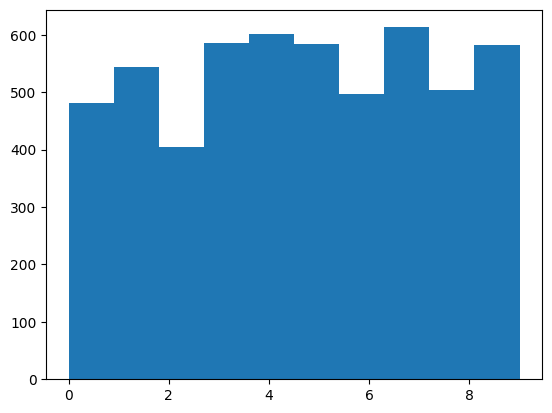

In [ ]:
plt.hist(targets, bins = 10)

S2
Accuracy: [0.81742739 0.88235294 0.7654321  0.96245734 0.99335548 0.92294521
 0.89738431 0.862969   0.9702381  0.9897084 ] mean:  0.9064270261694818
                      precision    recall  f1-score   support

             Highway     0.9403    0.8174    0.8746       482
               River     0.9057    0.8824    0.8939       544
             Pasture     0.9064    0.7654    0.8300       405
              Forest     0.8812    0.9625    0.9201       586
         Residential     0.9599    0.9934    0.9763       602
          AnnualCrop     0.9013    0.9229    0.9120       584
       PermanentCrop     0.8124    0.8974    0.8528       497
HerbaceousVegetation     0.8981    0.8630    0.8802       613
          Industrial     0.9645    0.9702    0.9674       504
             SeaLake     0.9569    0.9897    0.9730       583

            accuracy                         0.9122      5400
           macro avg     0.9127    0.9064    0.9080      5400
        weighted avg     0.9133    0.912

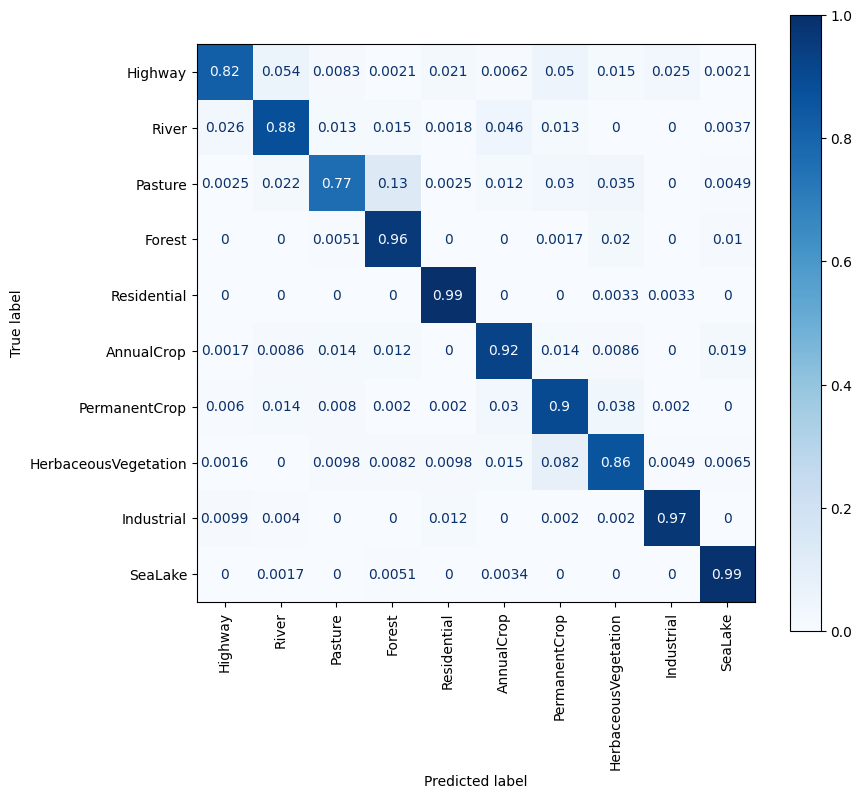

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (9,8))

cmd = ConfusionMatrixDisplay(cm, display_labels=[c.split('/')[-1] for c in handler.classes])
cmd.plot(ax=axes, cmap='Blues', xticks_rotation='vertical')
print('S2')
print('Accuracy:', cm.diagonal(), 'mean: ', cm.diagonal().mean())
print(classification_report(targets, predictions, target_names=[c.split('/')[-1] for c in handler.classes], digits=4))
axes.get_images()[0].set_clim(0, 1)
plt.show()
plt.close()